In [1]:
using FourierFlows
using JLD2
using CairoMakie

include("TwoLayerRaytracing.jl")

using .Raytracing

LoadError: SystemError: opening file "/home/nad9961/JuliaRaytracingSW/raytracing/Notebooks/TwoLayerRaytracing.jl": No such file or directory

In [2]:
nx, dt, prob = set_up_problem("initial_conditions/initial_condition_512x512_U=1.10_freely_evolve.jld2", "FilteredRK4", CPU())
grid = prob.grid

# Fix because this initial condition file actually has q as the streamfunction
ic_file = jldopen("initial_condition_U0.1.jld2")
index = keys(ic_file["snapshots/t"])[1]
qh = ic_file["snapshots/ψh/$index"]
@. prob.sol = qh
MultiLayerQG.updatevars!(prob)
println(keys(ic_file["params"]))
f₀ = ic_file["params/f₀"]
b = ic_file["params/b"]
H = ic_file["params/H"]
g′ = ic_file["params/g′"]
close(ic_file)

["f₀", "β", "b", "H", "U", "eta", "topographic_pv_gradient", "μ", "ν", "nν", "g′", "Qx", "Qy"]


RMS q 2.8555258652888966
RMS u 0.37276898098973504
RMS bt u 0.24884625349249678
Ld = 0.08000000000000003
barotropic Rossby number: 1.2442312674624838


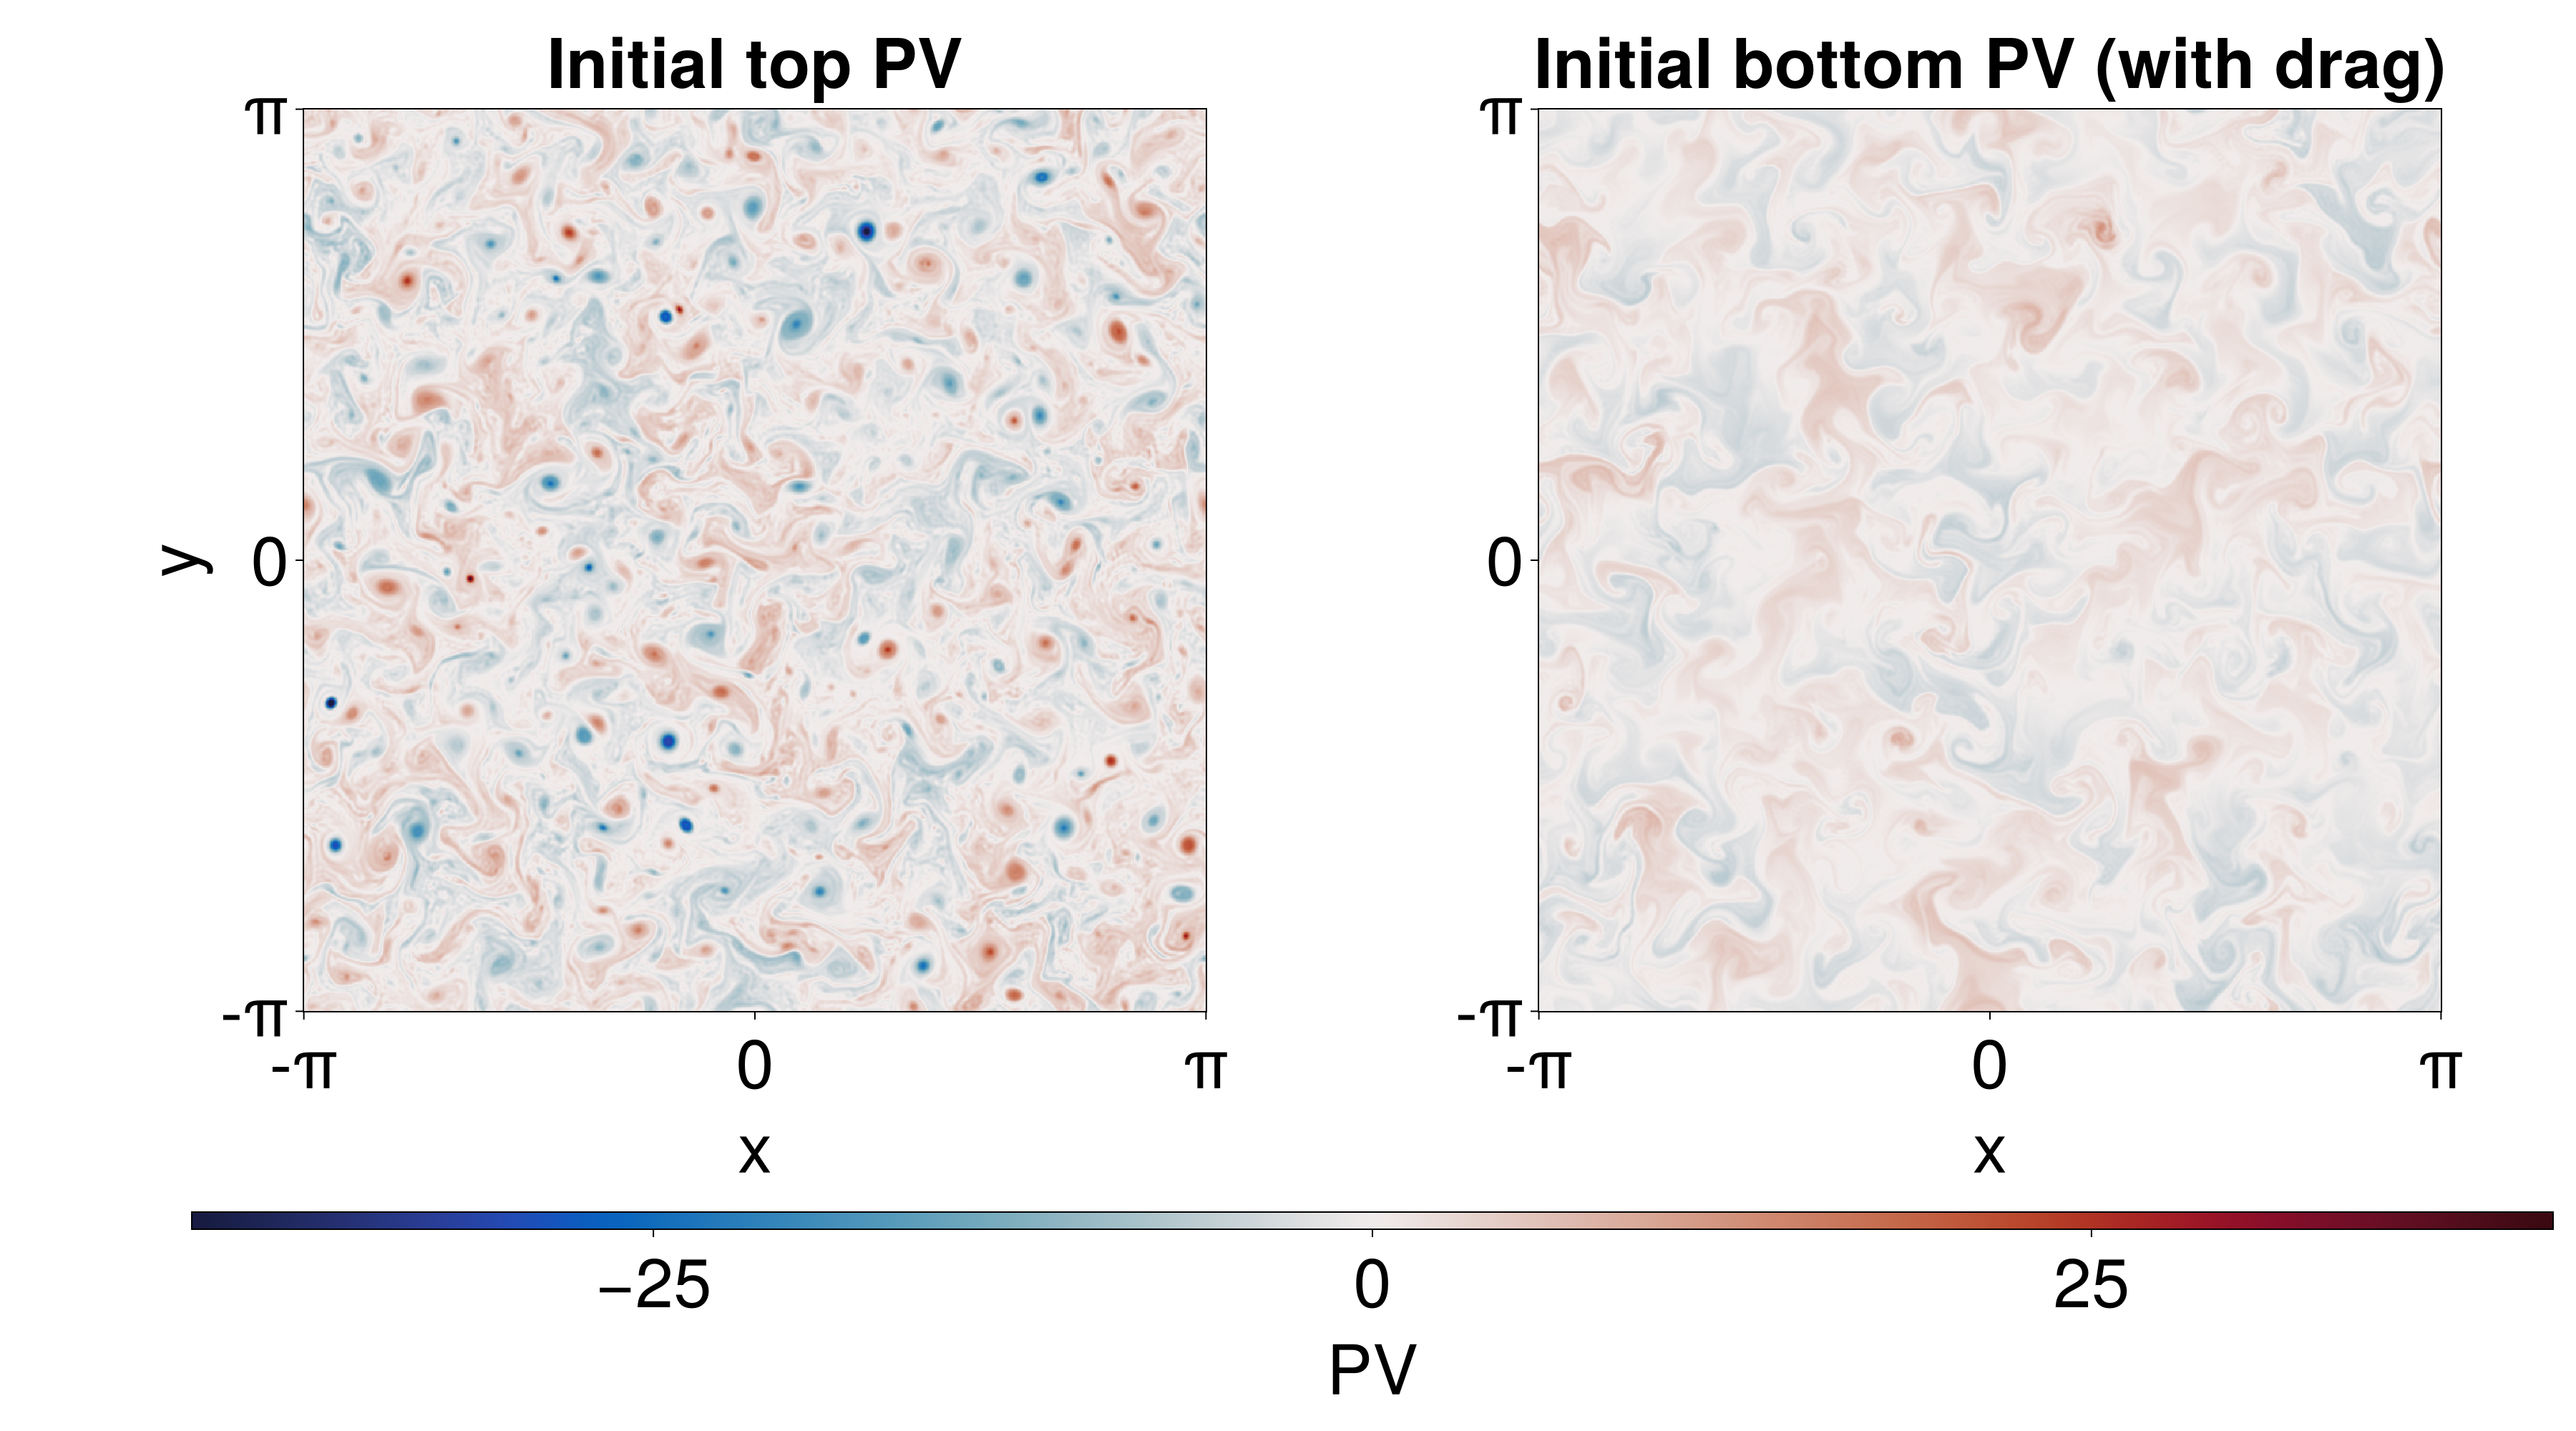

In [3]:
using Interpolations
field1 = prob.vars.q[:,:,1]
field2 = prob.vars.q[:,:,2]
cmax = max(maximum(field1), maximum(field2))
q1_field = linear_interpolation((grid.x, grid.y), field1, extrapolation_bc = Periodic())
q2_field = linear_interpolation((grid.x, grid.y), field2, extrapolation_bc = Periodic())
dims = 1024
plot_x = range(-grid.Lx/2, grid.Lx/2, dims)
plot_y = range(-grid.Lx/2, grid.Lx/2, dims)
plot1_field = q1_field(plot_x, plot_y)
plot2_field = q2_field(plot_x, plot_y)

fig = Figure(size=(200 * 9, 200 * 5), fontsize=48)
ax1 = Axis(fig[1, 1][1, 1]; 
        title = "Initial top PV", 
        xlabel="x",
        ylabel="y", 
        aspect=1, 
        xticks=([-π, 0, π], ["-π", "0", "π"]),
        yticks=([-π, 0, π], ["-π", "0", "π"]))
ax2 = Axis(fig[1,1][1, 2]; 
        title = "Initial bottom PV (with drag)", 
        xlabel="x", ylabel="", 
        aspect=1, 
        xticks=([-π, 0, π], ["-π", "0", "π"]),
        yticks=([-π, 0, π], ["-π", "0", "π"]))
hm = heatmap!(ax1, plot_x, plot_y, plot1_field, colormap=:balance, colorrange=(-cmax, cmax))
heatmap!(ax2, plot_x, plot_y, plot2_field, colormap=:balance, colorrange=(-cmax, cmax))

Colorbar(fig[2,1][1,1], hm, label="PV", vertical = false, flipaxis=false)
rms_q = sqrt(sum(prob.vars.q.^2 / grid.nx / grid.ny / 2))
btU = (prob.vars.u[:,:,1] + prob.vars.u[:,:,1])/2
btV = (prob.vars.v[:,:,1] + prob.vars.v[:,:,2])/2
rms_u = sqrt(sum((prob.vars.u.^2 + prob.vars.v.^2) / grid.nx / grid.ny / 2))
rms_btu = sqrt(sum((btU.^2 + btV.^2) / grid.nx / grid.ny))
println("RMS q ", rms_q)
println("RMS u ", rms_u)
println("RMS bt u ", rms_btu)
L = 2*π
Ld = sqrt(g′ * sum(H))/f₀
length_scale = 1/5
println("Ld = ", Ld)
println("barotropic Rossby number: ", rms_btu/length_scale)
save("initial_condition.png", fig)
fig

In [4]:
u1_background  = Array{Float64}(undef, grid.nx, grid.ny)
v1_background  = Array{Float64}(undef, grid.nx, grid.ny)
ux1_background = Array{Float64}(undef, grid.nx, grid.ny)
uy1_background = Array{Float64}(undef, grid.nx, grid.ny)
vx1_background = Array{Float64}(undef, grid.nx, grid.ny)
vy1_background = Array{Float64}(undef, grid.nx, grid.ny)


velocity = Raytracing.Velocity(u1_background, v1_background)
grad_velocity = Raytracing.VelocityGradient(ux1_background, uy1_background, vx1_background, vy1_background)

temp_field = Array{Complex{Float64}}(undef, grid.nkr, grid.nl)
temp_field1 = Array{Float64}(undef, grid.nx, grid.ny)

avg_velocity = sum(sqrt.((prob.vars.u[:,:,1].^2 + prob.vars.v[:,:,1].^2)))/grid.nx/grid.ny
println(avg_velocity)
Fr = 0.2
scaled_field = Fr * prob.vars.ψh[:,:,1] / avg_velocity
scaled_field =prob.vars.ψh[:,:,1]
get_velocity_info(scaled_field, grid, (), velocity, grad_velocity, temp_field, temp_field1);

sqrtNpackets = 6
Npackets = sqrtNpackets^2
initial_packets = generate_initial_wavepackets(grid.Lx, 2., Npackets, sqrtNpackets)

0.35368208120546296


36-element Vector{Main.Raytracing.Wavepacket}:
 Main.Raytracing.Wavepacket([-2.6179938779914944, -2.6179938779914944], [1.969615506024416, 0.34729635533386066], [0.0, 0.0])
 Main.Raytracing.Wavepacket([-2.6179938779914944, -1.5707963267948966], [1.8793852415718169, 0.6840402866513374], [0.0, 0.0])
 Main.Raytracing.Wavepacket([-2.6179938779914944, -0.5235987755982988], [1.7320508075688774, 0.9999999999999999], [0.0, 0.0])
 Main.Raytracing.Wavepacket([-2.6179938779914944, 0.5235987755982986], [1.532088886237956, 1.2855752193730785], [0.0, 0.0])
 Main.Raytracing.Wavepacket([-2.6179938779914944, 1.570796326794897], [1.2855752193730787, 1.532088886237956], [0.0, 0.0])
 Main.Raytracing.Wavepacket([-2.6179938779914944, 2.6179938779914944], [1.0000000000000002, 1.7320508075688772], [0.0, 0.0])
 Main.Raytracing.Wavepacket([-1.5707963267948966, -2.6179938779914944], [0.6840402866513376, 1.8793852415718166], [0.0, 0.0])
 Main.Raytracing.Wavepacket([-1.5707963267948966, -1.5707963267948966], [0.34

In [5]:
function trace_packets!(velocity, grad_velocity, packets, nsteps, nsubs, dt, packet_params)
    frames = 0:round(Int, nsteps / nsubs)
    clock = (t = t, step = 0)
    timestep = nsubs * dt
    
    t_hist = Array{Float64}(undef, 1+length(frames))
    x_hist = Array{Float64}(undef, 1+length(frames), Npackets, 2)
    k_hist = Array{Float64}(undef, 1+length(frames), Npackets, 2)
    # savepackets!(out, clock, packets)
    startwalltime = time()
    t_hist[1] = 0
    for i = 1:Npackets
        x_hist[1, i, 1] = packets[i].x[1]
        x_hist[1, i, 2] = packets[i].x[2]
        k_hist[1, i, 1] = packets[i].k[1]
        k_hist[1, i, 2] = packets[i].k[2]
    end
    for j=frames
        if (j % (1000 / nsubs) == 0)
            log = @sprintf("step: %04d, t: %.1f, walltime: %.2f min",
                           clock.step, clock.t, (time()-startwalltime)/60)
            println(log)
        end
        new_t = clock.t + timestep;
        Raytracing.solve!(velocity,  grad_velocity, 
            grid.x, grid.y, packet_params.Npackets, packets, dt, (clock.t, new_t), packet_params);
        t_hist[j+2] = new_t
        for i = 1:Npackets
            x_hist[j+2, i, 1] = packets[i].x[1]
            x_hist[j+2, i, 2] = packets[i].x[2]
            k_hist[j+2, i, 1] = packets[i].k[1]
            k_hist[j+2, i, 2] = packets[i].k[2]
        end
        # stepraysforward!(grid, packets, old_v, new_v, (old_t / packet_params.packetVelocityScale, new_t / packet_params.packetVelocityScale), packet_params);
        t = new_t;
        clock = (t = t, step = clock.step + nsubs)
        # savepackets!(out, clock, packets); # Save with latest velocity information
    end
    return t_hist, x_hist, k_hist
end

trace_packets! (generic function with 1 method)

In [7]:
nsteps = 10000
nsubs = 1

dt = 1e-4
t = 0.
packet_params = (f=1., Cg = 1., Npackets=Npackets)
packets = deepcopy(initial_packets)
t_hist, x_hist, k_hist = trace_packets!(velocity, grad_velocity, packets, nsteps, nsubs, dt, packet_params)

step: 0000, t: 0.0, walltime: 0.00 min
step: 1000, t: 0.8, walltime: 0.77 min
step: 2000, t: 1.6, walltime: 1.53 min
step: 3000, t: 2.4, walltime: 2.29 min
step: 4000, t: 3.2, walltime: 3.05 min
step: 5000, t: 4.0, walltime: 3.82 min
step: 6000, t: 4.8, walltime: 4.58 min
step: 7000, t: 5.6, walltime: 5.34 min
step: 8000, t: 6.4, walltime: 6.10 min
step: 9000, t: 7.2, walltime: 6.87 min
step: 10000, t: 8.0, walltime: 7.63 min


([0.0, 0.0008, 0.0016, 0.0024000000000000002, 0.0032, 0.004, 0.0048000000000000004, 0.005600000000000001, 0.006400000000000001, 0.0072000000000000015  …  7.99359999999925, 7.99439999999925, 7.99519999999925, 7.99599999999925, 7.99679999999925, 7.99759999999925, 7.99839999999925, 7.99919999999925, 7.9999999999992495, 8.00079999999925], [-2.6179938779914944 -2.6179938779914944 … 2.6179938779914944 2.6179938779914944; -2.6173329734884527 -2.6173487374153885 … 2.6187013075758543 2.6187332022058256; … ; -2.6440657320981744 -1.4442036480815645 … 4.848777705210971 7.350294336065196; -2.6441848767381764 -1.4445718130643883 … 4.848756497594823 7.350631667613172;;; -2.6179938779914944 -1.5707963267948966 … 1.570796326794897 2.6179938779914944; -2.6176462649137435 -1.5702153683170015 … 1.5711001517034011 2.617912399741255; … ; -1.8049020185696907 -4.610175272021491 … 0.632266909716988 3.7212788542701136; -1.8051106752037447 -4.610408563802341 … 0.6322028777561309 3.7202898717771404], [1.969615506

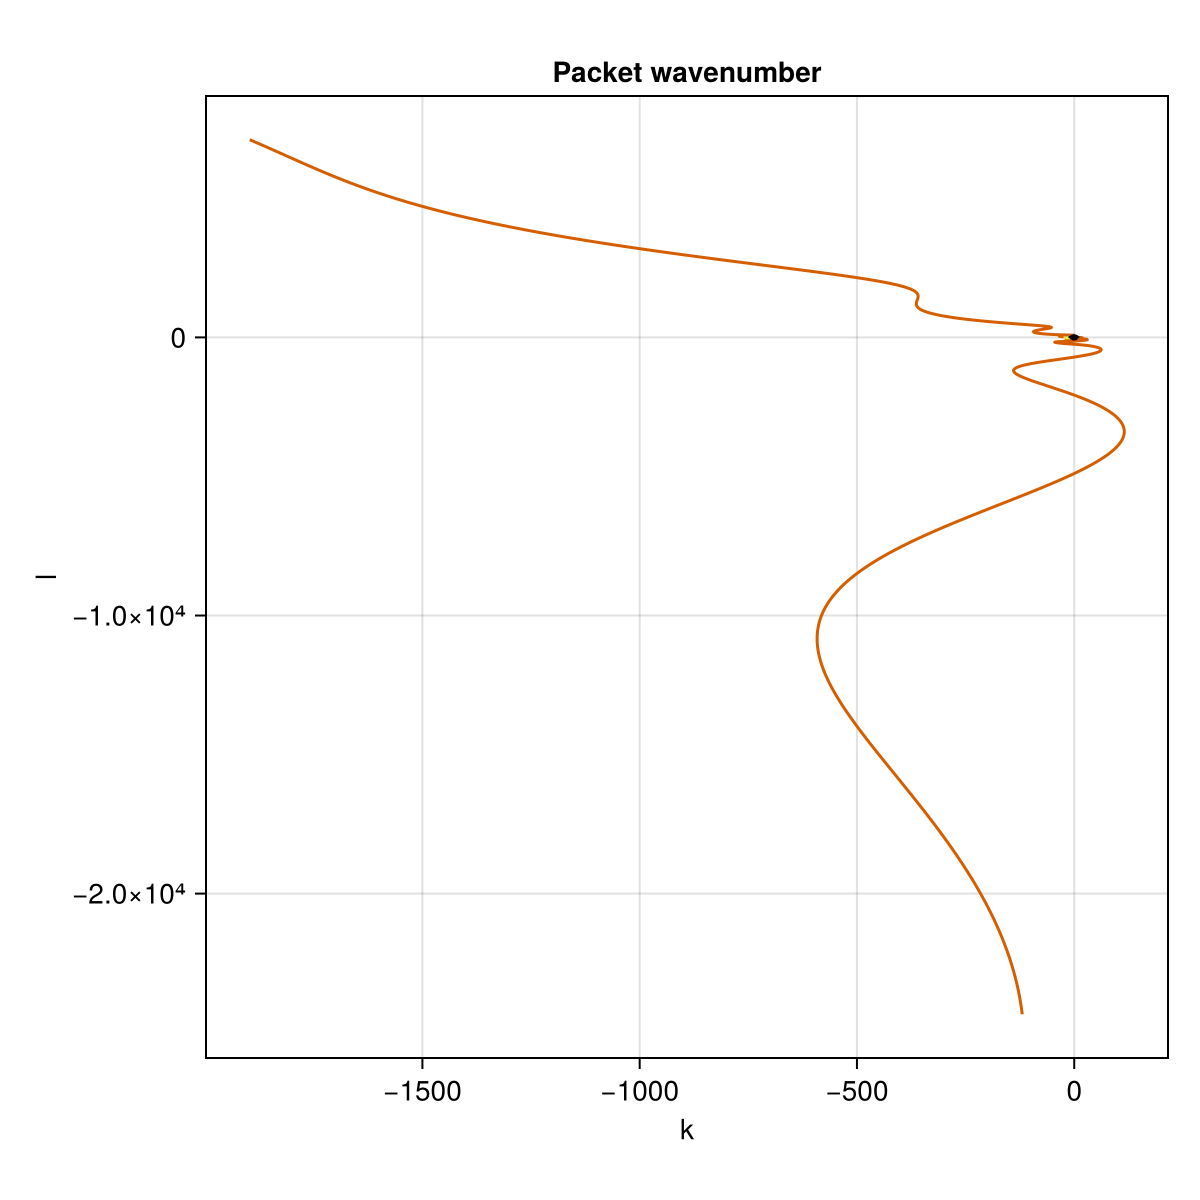

In [8]:
fig = Figure(size=(600, 600))
ax = Axis(fig[1, 1]; title = "Packet wavenumber", xlabel="k", ylabel="l", aspect=1)

for i=1:Npackets
    lines!(ax, k_hist[:,i,1], k_hist[:,i,2])
end
lines!(ax, k_hist[1,:,1], k_hist[1,:,2], color="black", linewidth=3)
fig

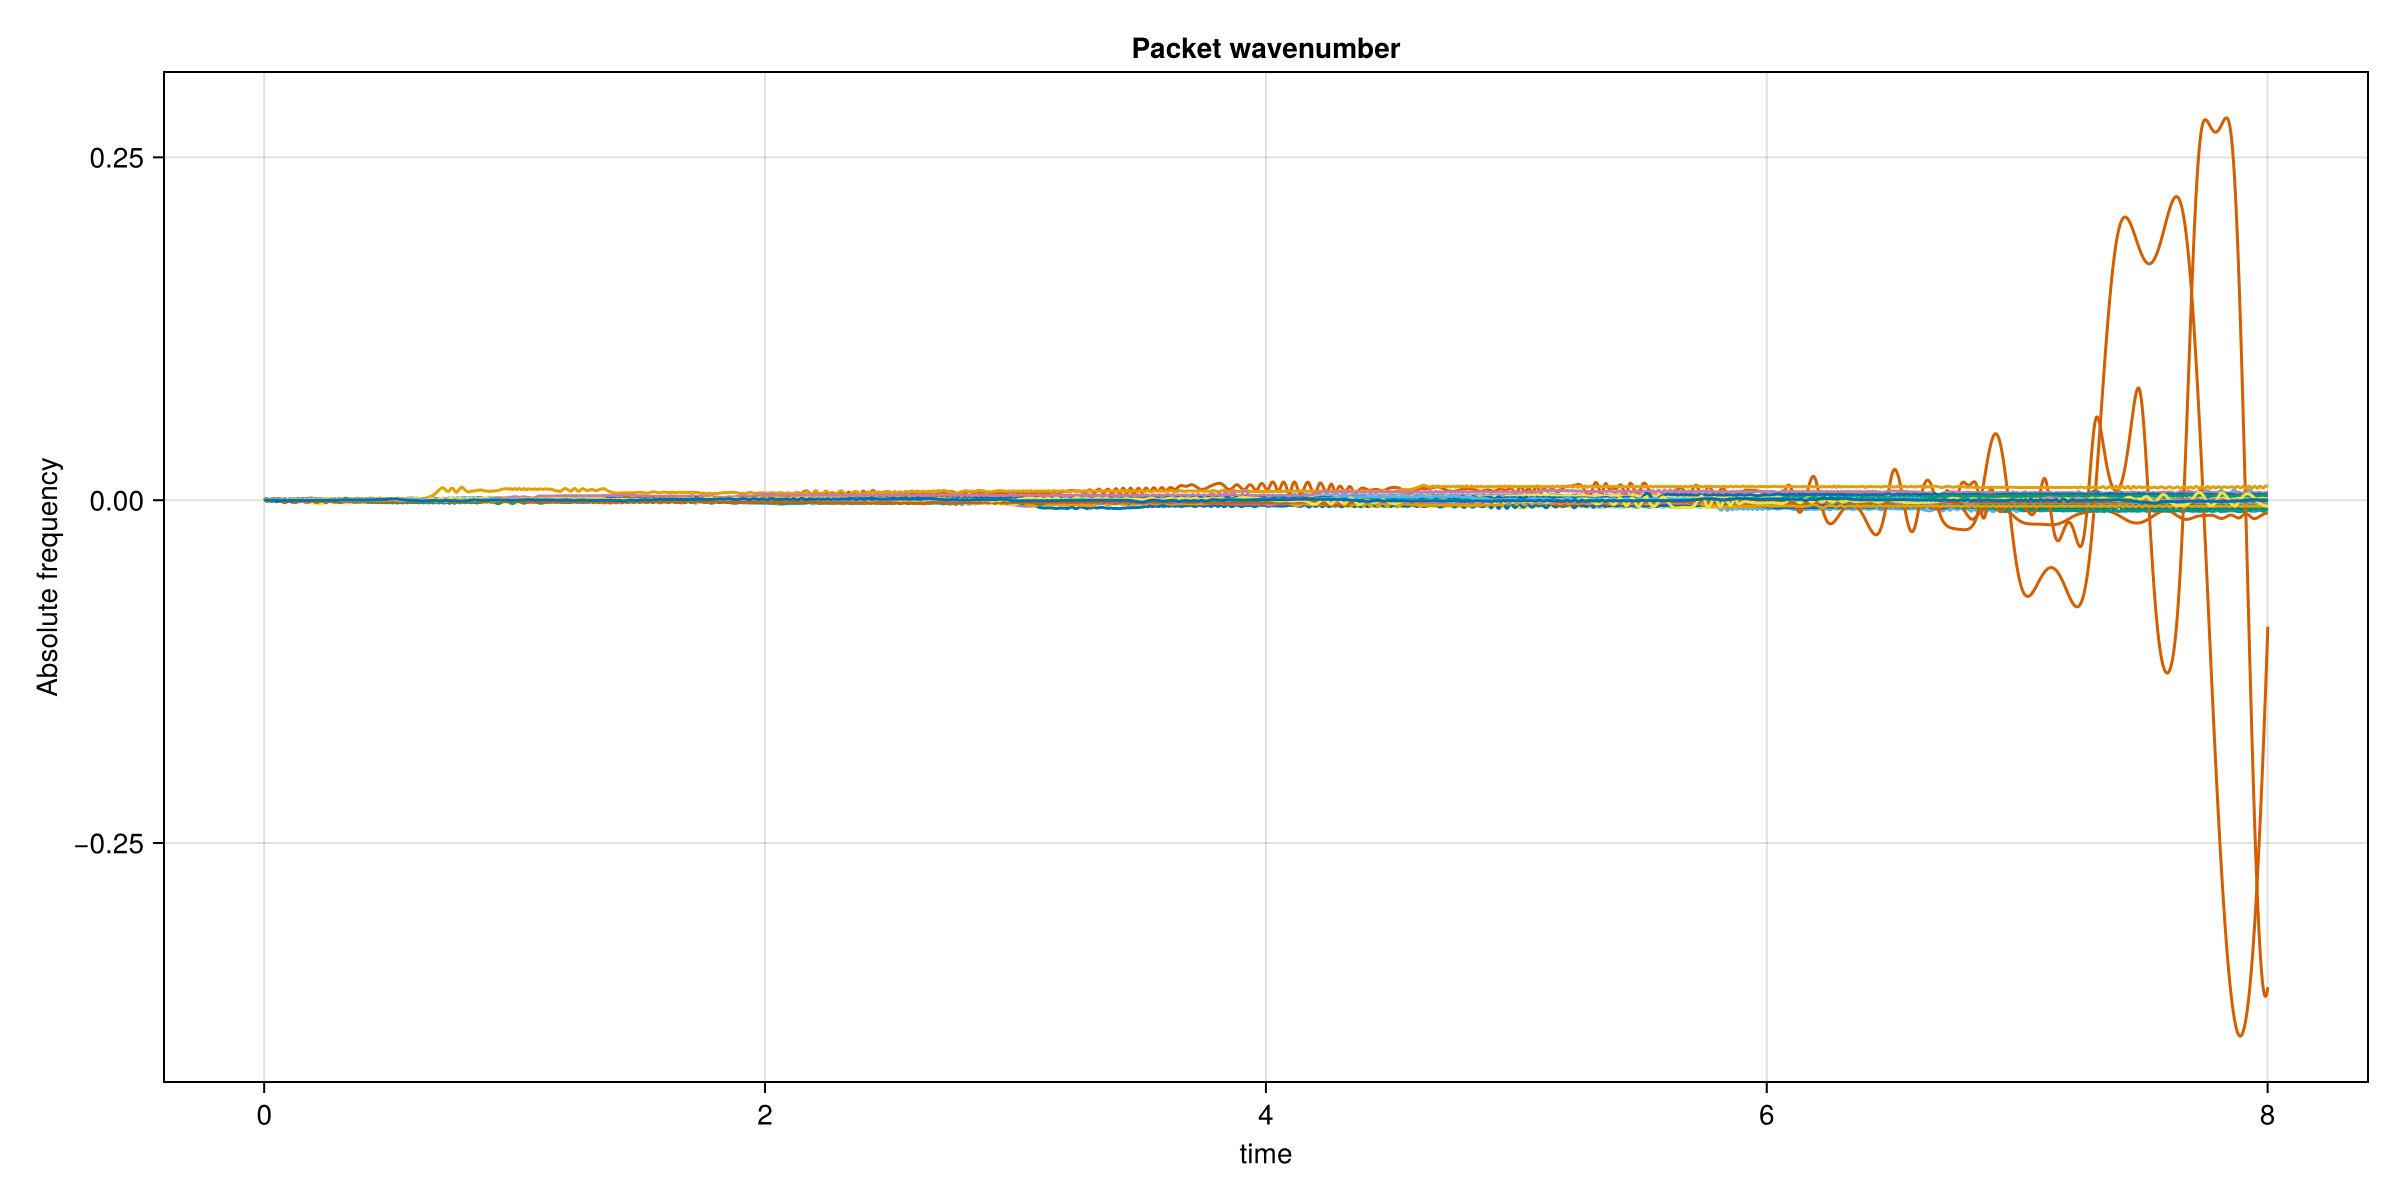

In [9]:
vel_itp = Raytracing.createVelocityInterpolator(velocity, grid.x, grid.y)
omega(k, l) = sqrt(packet_params.f^2 + packet_params.Cg^2*(k^2 + l^2))
Omega(x, y, k, l) = vel_itp.u(x, y) * k + vel_itp.v(x, y) * l + omega(k, l)

fig = Figure(size=(1200, 600))
ax = Axis(fig[1, 1]; title = "Packet wavenumber", xlabel="time", ylabel="Absolute frequency")

for i=1:Npackets
    initial_omega = Omega(x_hist[1,i,1], x_hist[1,i,2], k_hist[1,i,1], k_hist[1,i,2])
    lines!(ax, t_hist, Omega.(x_hist[:,i,1], x_hist[:,i,2], k_hist[:,i,1], k_hist[:,i,2]) .- initial_omega)
end

fig